<a href="https://colab.research.google.com/github/Vinaypatil-Ev/vinEvPy-GoCoLab/blob/main/Tensorflow/TensorflowPrac7_advance_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)# advance autodiff

## advance automatic differentiation

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

## Controlling automactic gradient recording

### 1. *GradientTape().stop_recording()*

In [ ]:
x = tf.Variable(3.0)
y = tf.Variable(2.0)
wrt = {"x": x, "y": y}

def Grad(grad):
  print(grad["x"])
  print(grad["y"])

In [ ]:
with tf.GradientTape() as tape:
  x2 = x * x
  with tape.stop_recording():
    y2 = y * y
  
  z = x2 + y2

grad = tape.gradient(z, wrt)

### 2. GradientTape().reset()

In [ ]:
with tf.GradientTape() as tape:
  y2 = y * y 
  tape.reset()
  x2 = x * x

  z = x2 + y2

grad = tape.gradient(z, wrt)
Grad(grad)

tf.Tensor(6.0, shape=(), dtype=float32)
None


### 3. *tf.stop_gradient()*

In [ ]:
with tf.GradientTape() as tape:
  x2 = x * x
  y2 = y * y

  z = x2 + tf.stop_gradient(y2)

grad = tape.gradient(z, wrt)
Grad(grad)

tf.Tensor(6.0, shape=(), dtype=float32)
None


## Custom Gradients



### Controlling Gradient
1. modify the value - 
  * *tf.clip_by_value()*, 
  * *tf.math.round()*, 
  * *tf.clip_by_norm()*

### To write new gradient ops use
  * *tf.costom_gradient* 

In [ ]:
@tf.custom_gradient
def clip_gradient(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 1)
  return y, backward

In [ ]:
v = tf.Variable(5.0)
with tf.GradientTape() as tape:
  z = clip_gradient(v * v)

tape.gradient(z, v)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

### Multiple tapes

In [ ]:
v = tf.Variable(0.0)
u = tf.Variable(0.0)
with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
  tape1.watch(u)
  tape2.watch(v)

  x = tf.math.sin(u)
  y = tf.nn.sigmoid(v)

  w = 2 * x + 6 * y ** 2

  z = tf.reduce_sum(w)

In [ ]:
tape1.gradient(z, u) # 2 * d_du(x) + 6 * d_du(y ** 2) => 2 * d_du(sin(u)) + 0 => 2 * cos(0) = 2

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
tape2.gradient(w, v) # 0 + 6 * d_dv(y ** 2) => 6 * 2 * sig(v) * sig(v)*(1 - sig(v))

<tf.Tensor: shape=(), dtype=float32, numpy=1.5>

In [ ]:
tf.nn.sigmoid(tf.Variable(0.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
12 * 0.5 * 0.5 * (1 - 0.5)

1.5

### Higher order gradient

In [ ]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape2:
  with tf.GradientTape() as tape1:
    y = x * x * x
    d_dx = tape1.gradient(y, x)
d2_dx2 = tape2.gradient(d_dx, x)


In [ ]:
print('d_dx:', d_dx) 
print('d2_dx2:', d2_dx2)

d_dx: tf.Tensor(3.0, shape=(), dtype=float32)
d2_dx2: tf.Tensor(6.0, shape=(), dtype=float32)


### Input gradient Regularization:
1. calculate gradient of output with respect to input using inner tape
2. calculate magnitude of that input gradient
3. calculate gradient of magnitude with respect to model

In [ ]:
x = tf.random.normal([7, 6])
layer = tf.keras.layers.Dense(10, activation="relu")

In [ ]:
with tf.GradientTape() as tape1:
  with tf.GradientTape() as tape2:
    tape2.watch(x)
    y = layer(x)
    out = tf.reduce_sum(y**2)

  input = tape2.gradient(out, x)
  mag = tf.norm(input)

grad = tape1.gradient(mag, layer.trainable_variables)
[var.shape for var in grad ]

[TensorShape([6, 10]), TensorShape([10])]

## Jacobians

### jacobian matrix: It is matrix of gradients of vector valued function 

### *GradientTape().jacobian()*

#### 1. scalar source

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)
with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x + delta)
d_dx = tape.jacobian(y, delta)
d_dx.shape

TensorShape([201])

#### 2. tensor source

In [ ]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)
with tf.GradientTape() as tape:
  y = layer(x)
gradj = tape.jacobian(y, layer.trainable_variables)
[var.shape for var in gradj]

[TensorShape([7, 10, 5, 10]), TensorShape([7, 10, 10])]

In [ ]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)
with tf.GradientTape() as tape:
  y = layer(x)
gradk = tape.gradient(y, layer.trainable_variables)
[var.shape for var in gradk]

[TensorShape([5, 10]), TensorShape([10])]

In [ ]:
j = tf.reduce_sum(gradj[0], axis=[0, 1])

In [ ]:
delta = tf.reduce_max(abs(gradk[0] - j)).numpy()
delta

5.967914

### Hessein matrix

In [ ]:
x = tf.random.normal([5, 6])
layer1 = tf.keras.layers.Dense(7, activation="relu")
layer2 = tf.keras.layers.Dense(8, activation="relu")

In [ ]:
with tf.GradientTape() as tape:
  with tf.GradientTape() as tapei:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)
  
  d_dx = tapei.gradient(loss, layer1.kernel)

grad = tape.jacobian(d_dx, layer1.kernel)

In [ ]:
grad.shape

TensorShape([6, 7, 6, 7])

In [ ]:
layer1.kernel.shape

TensorShape([6, 7])

In [ ]:
layer2.kernel.shape

TensorShape([7, 8])

In [ ]:
n_params = tf.reduce_prod(layer1.kernel.shape)
n_params

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
g = tf.reshape(d_dx, [n_params, 1])
h = tf.reshape(grad, [n_params, n_params])

In [ ]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

In [ ]:
def hm_show(img):
  lim = tf.reduce_max(abs(img))
  plt.imshow(img, vmin=-lim, vmax=lim, cmap="seismic")
  plt.colorbar()

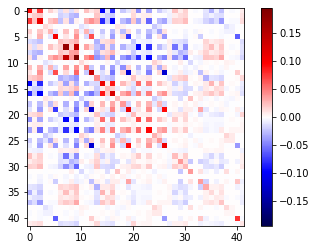

In [ ]:
hm_show(h)

In [ ]:
1e-2

0.01

In [ ]:
eye = tf.eye(h.shape[0]) * 1e-3

In [ ]:
update = tf.linalg.solve(h + eye, g)

In [ ]:
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

In [ ]:
layer1.kernel == update

<tf.Tensor: shape=(), dtype=bool, numpy=False>

## Batch jacobian

In [ ]:
x = tf.random.normal([6, 7]) 
layer1 = tf.keras.layers.Dense(10, activation="elu")
layer2 = tf.keras.layers.Dense(10, activation="elu")

In [ ]:
with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

In [ ]:
tape.jacobian(y, x).shape

TensorShape([6, 10, 6, 7])

In [ ]:
tape.batch_jacobian(y, x).shape

TensorShape([6, 10, 7])

In [ ]:
bn = tf.keras.layers.BatchNormalization()

In [ ]:
with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

In [ ]:
tape.jacobian(y, x).shape

TensorShape([6, 10, 6, 7])

In [ ]:
tape.batch_jacobian(y, x).shape

TensorShape([6, 10, 7])